## Engineering Notebook

---

In this notebook, we analyze the extracted features, assessing the necessity of normalization. We also investigate possible feature selection techniques to reduce the dimensionality of the data.
The sections are organized as follows:

1. [Load Data](#Load-Data)
2. [Feature Analysis](#2.-Feature-Analysis)
3. [Feature Selection](#3.-Feature-Selection)
4. [Feature Normalization](#4.-Feature-Normalization)


In [20]:
# import all the functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import print_correlation, detect_outliers_iqr
from sklearn.decomposition import PCA

### 1. Load Data <a id='Load-Data'></a>


In [21]:
# paths to the features and the labels
FEATURES_RAW_DIR = "../features/raw/"

In [22]:
names = os.listdir(FEATURES_RAW_DIR)
name_labels = {}
data_list = []
data_list_name = []

for name in names:
    data = np.load(FEATURES_RAW_DIR + name)
    X = data["X"]
    y = data["y"].reshape(-1, 1)
    filename = data["filename"].reshape(-1, 1)

    # update dictionary
    name_labels[name.split("_")[0]] = y[0, 0]

    data = np.concatenate((X, y), axis=1)
    data_name = np.concatenate((data, filename), axis=1)
    data_list.append(data)
    data_list_name.append(data_name)

columns = [f"MFCC {i}" for i in range(1, 21)] + [
    "Chroma STFT",
    "RMS",
    "Spectral Centroid",
    "Spectral Bandwidth",
    "Spectral Rolloff",
    "Zero Crossing Rate",
]
# sort the name_labels dictionary by the labels
name_labels = dict(sorted(name_labels.items(), key=lambda item: item[1]))

# create the full data matrix
data = np.concatenate(data_list, axis=0)
data_name = np.concatenate(
    data_list_name, axis=0
)  # data with the index of the filename in the last column

data_df = pd.DataFrame(data, columns=columns + ["label"])

### 2. Feature Analysis


#### 2.1. Visualize Features


In [23]:
data_df.describe().transpose()

count         mean          std          min         25%  \
MFCC 1              5681.0  -349.530394   170.782002 -1131.369385 -493.868927   
MFCC 2              5681.0    64.244121    56.439627  -147.508499   26.992205   
MFCC 3              5681.0   -22.966034    55.470573  -202.986023  -62.053368   
MFCC 4              5681.0    14.726614    26.046964   -81.728157   -3.964456   
MFCC 5              5681.0    -9.247497    20.869864   -93.464005  -18.721048   
MFCC 6              5681.0     7.822334    12.622203   -59.051239   -0.505688   
MFCC 7              5681.0   -10.322080    11.743821   -60.654026  -14.977498   
MFCC 8              5681.0     4.769984    12.051124   -50.738564   -3.965688   
MFCC 9              5681.0    -9.263391    11.013362   -61.882683  -11.199246   
MFCC 10             5681.0    -0.270526     9.828711   -34.488117   -6.228393   
MFCC 11             5681.0    -6.378389     8.254406   -46.267017   -8.577553   
MFCC 12             5681.0    -1.818134     6.542171   -37.016983   -5.510853   
MFCC 13             5681.0    -1.351583     6.117713   -26.072718   -4.839550   
MFCC 14             5681.0    -5.374463     8.301175   -37.656418   -7.262198   
MFCC 15             5681.0    -2.332236     4.466969   -29.391104   -5.022358   
MFCC 16             5681.0    -4.624890     5.995429   -35.502090   -7.794633   
MFCC 17             5681.0    -4.051200     4.239208   -29.948135   -6.262334   
MFCC 18             5681.0    -4.909371     5.744222   -34.217995   -7.653966   
MFCC 19             5681.0    -1.871714     5.249195   -22.969372   -4.201708   
MFCC 20             5681.0    -4.764999     3.988860   -19.744410   -6.518013   
Chroma STFT         5681.0     0.628214     0.130414     0.000000    0.594187   
RMS                 5681.0     0.063324     0.073323     0.000000    0.016409   
Spectral Centroid   5681.0  1647.488552  2254.808922     0.000000  280.727843   
Spectral Bandwidth  5681.0  1978.908613  1915.189161     0.000000  335.706527   
Spectral Rolloff    5681.0  3275.388685  4305.215345     0.000000  505.126953   
Zero Crossing Rate  5681.0     0.079385     0.085287     0.000000    0.037008   
label               5681.0     1.741419     1.384849     0.000000    0.000000   

                           50%          75%           max  
MFCC 1             -285.770935  -218.800598     68.951576  
MFCC 2               74.836853   106.796501    175.095840  
MFCC 3               -0.769553    18.862932     73.765327  
MFCC 4               19.284504    33.805252     69.192734  
MFCC 5               -3.079588     5.599082     52.038036  
MFCC 6               10.359822    17.192474     67.920410  
MFCC 7               -8.494186    -2.905097     29.086437  
MFCC 8                7.658669    12.899904     52.486908  
MFCC 9               -6.001773    -2.886022     27.975435  
MFCC 10               1.394493     5.054112     40.268581  
MFCC 11              -4.957301    -2.233807     33.968838  
MFCC 12              -0.673915     2.706082     31.760628  
MFCC 13              -2.590562     0.365707     35.062443  
MFCC 14              -2.965885    -0.391790     22.887892  
MFCC 15              -2.216128     0.465690     35.968140  
MFCC 16              -3.491596    -0.510015     16.646555  
MFCC 17              -3.554286    -1.150033     17.689093  
MFCC 18              -3.504787    -0.953457     14.318357  
MFCC 19              -0.824334     1.442447     14.322778  
MFCC 20              -4.050161    -2.236612     21.857550  
Chroma STFT           0.658797     0.709724      0.922434  
RMS                   0.047106     0.083113      0.648416  
Spectral Centroid   474.238218  2165.398822  17722.002210  
Spectral Bandwidth  935.737677  3379.235746   7319.498536  
Spectral Rolloff    775.878906  4704.138605  21160.455954  
Zero Crossing Rate    0.061829     0.094910      0.776468  
label                 2.000000     3.000000      4.000000

#### 2.2. Feature Correlation


#### Test Normalità


In [24]:
import scipy.stats as stats

p_values = []
test_val = []

# Calcola il test di normalità per ciascuna colonna del dataframe
for column in data_df.columns:
    test = stats.normaltest(data_df[column])
    p_values.append(test[1])
    test_val.append(test[0])

# Crea un dataframe contenente i risultati del test di normalità
norm_df = pd.DataFrame(
    {"Feature": data_df.columns, "D'Agostino-Pearson": test_val, "P-value": p_values}
)

norm_df.set_index("Feature", inplace=True)


# Definisci una funzione per colorare le celle in base al p-value
def color_cells(val):
    color = (
        "green" if val >= 0.05 else "red"
    )  # Assumendo un livello di significatività del 0.05
    if val > 1:
        color = None
    return "background-color: %s" % color


# Applica la funzione di colorazione al DataFrame
styled_norm_df = norm_df.style.applymap(color_cells)

styled_norm_df

/tmp/ipykernel_93009/3873497847.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_norm_df = norm_df.style.applymap(color_cells)


#### Compute the correlation coefficient between the features and the target variable.


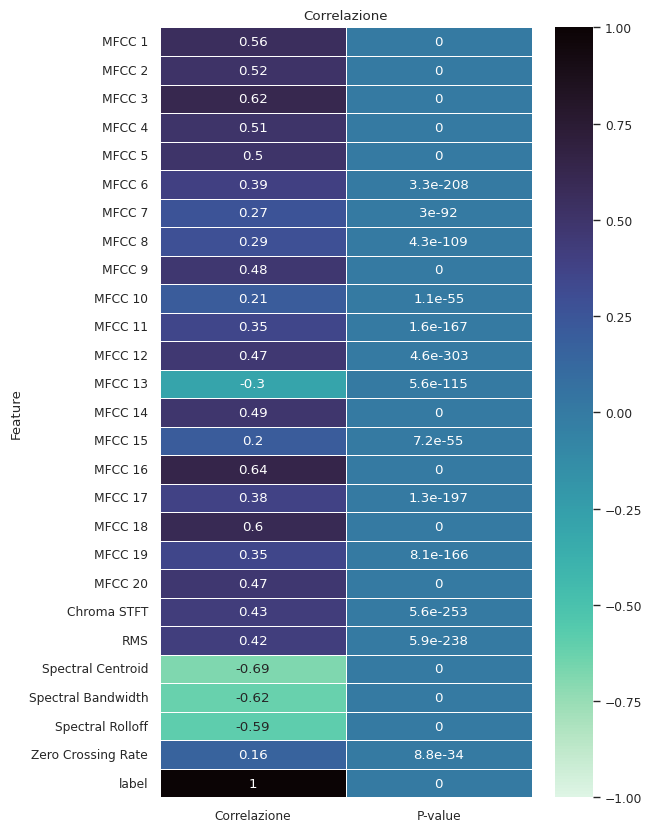

In [25]:
from scipy.stats import spearmanr
import seaborn as sns

# Importa le librerie necessarie
p_values = []
correlazione = []
features = []
# Calcola i coefficienti di correlazione di Kendall e i valori p per ogni coppia di colonne nel dataframe
for col1 in data_df.columns:
    correlation, p_value = spearmanr(data_df[col1], data_df["label"])
    p_values.append(p_value)
    correlazione.append(correlation)
    features.append(col1)

correlazione_df = pd.DataFrame(
    {"Feature": features, "Correlazione": correlazione, "P-value": p_values}
)

correlazione_df.set_index("Feature", inplace=True)
plt.figure(figsize=(6, 10))
sns.heatmap(correlazione_df, annot=True, cmap="mako_r", linewidths=0.5, vmax=1, vmin=-1)
plt.title("Correlazione")
plt.show()

#### Plot correlation matrix  
Since there are a lot of features, it's quite confusing and difficult to analyze the whole correlation matrix. So, whe split the covariance matrix into three parts: first 10 features, next 10 features, and the rest of the features, in all groups is present the target variable as the last column.


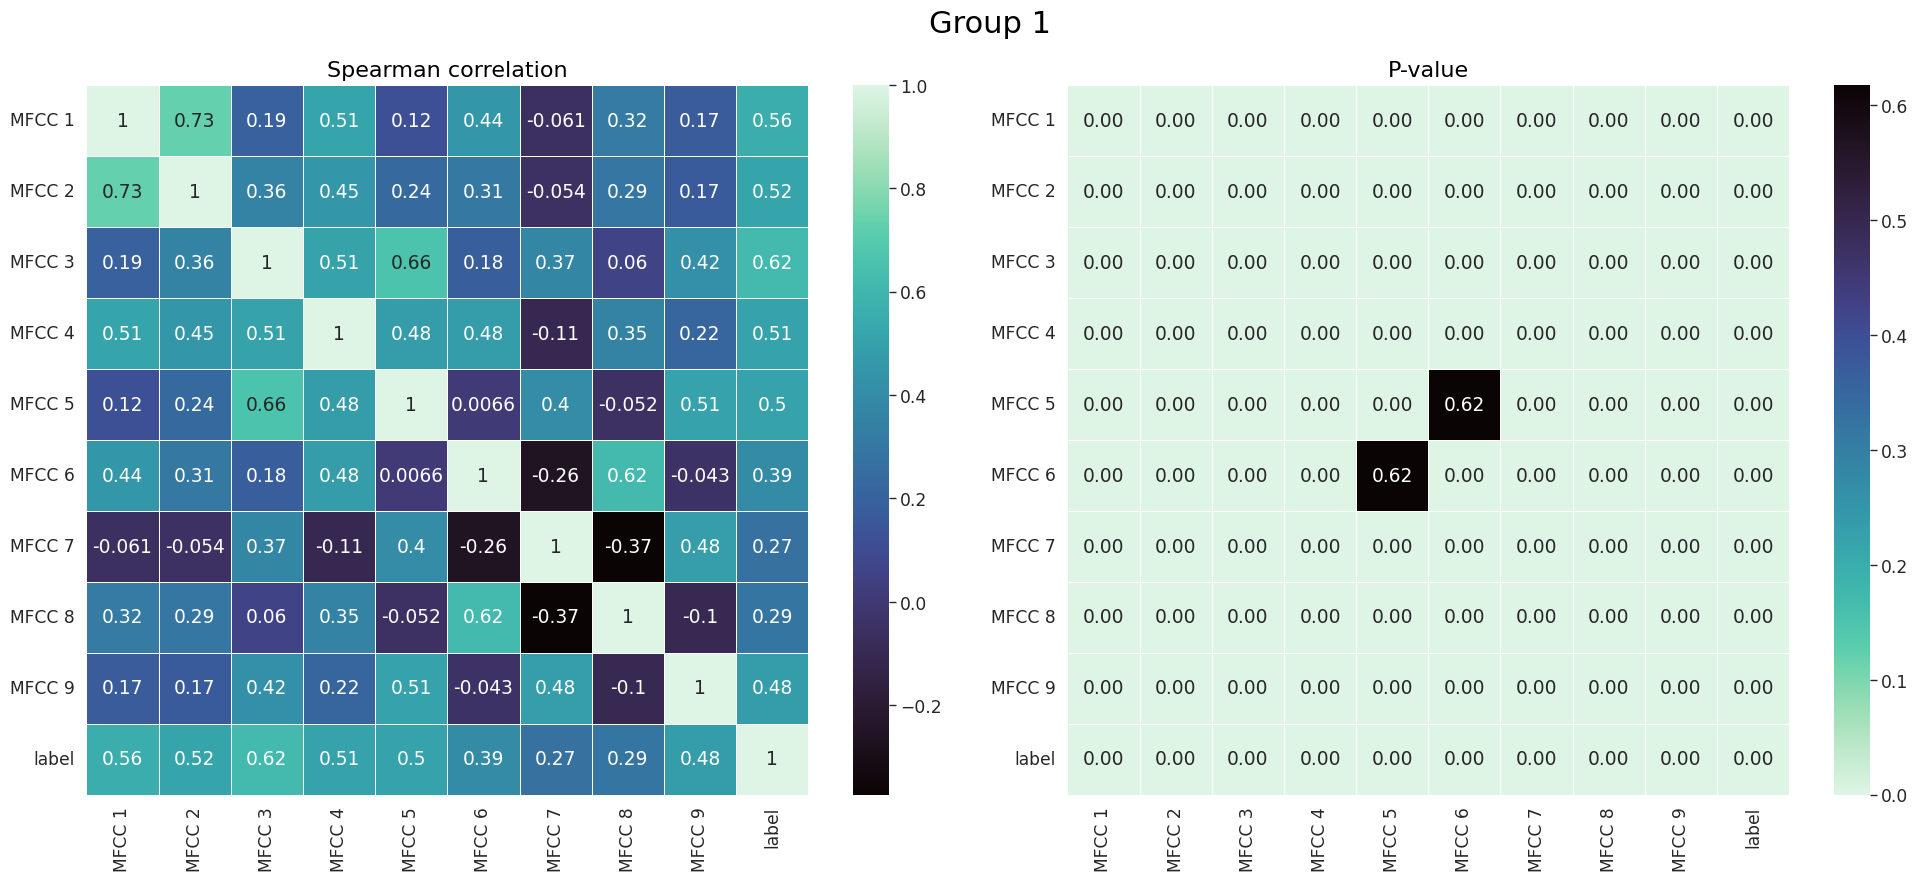

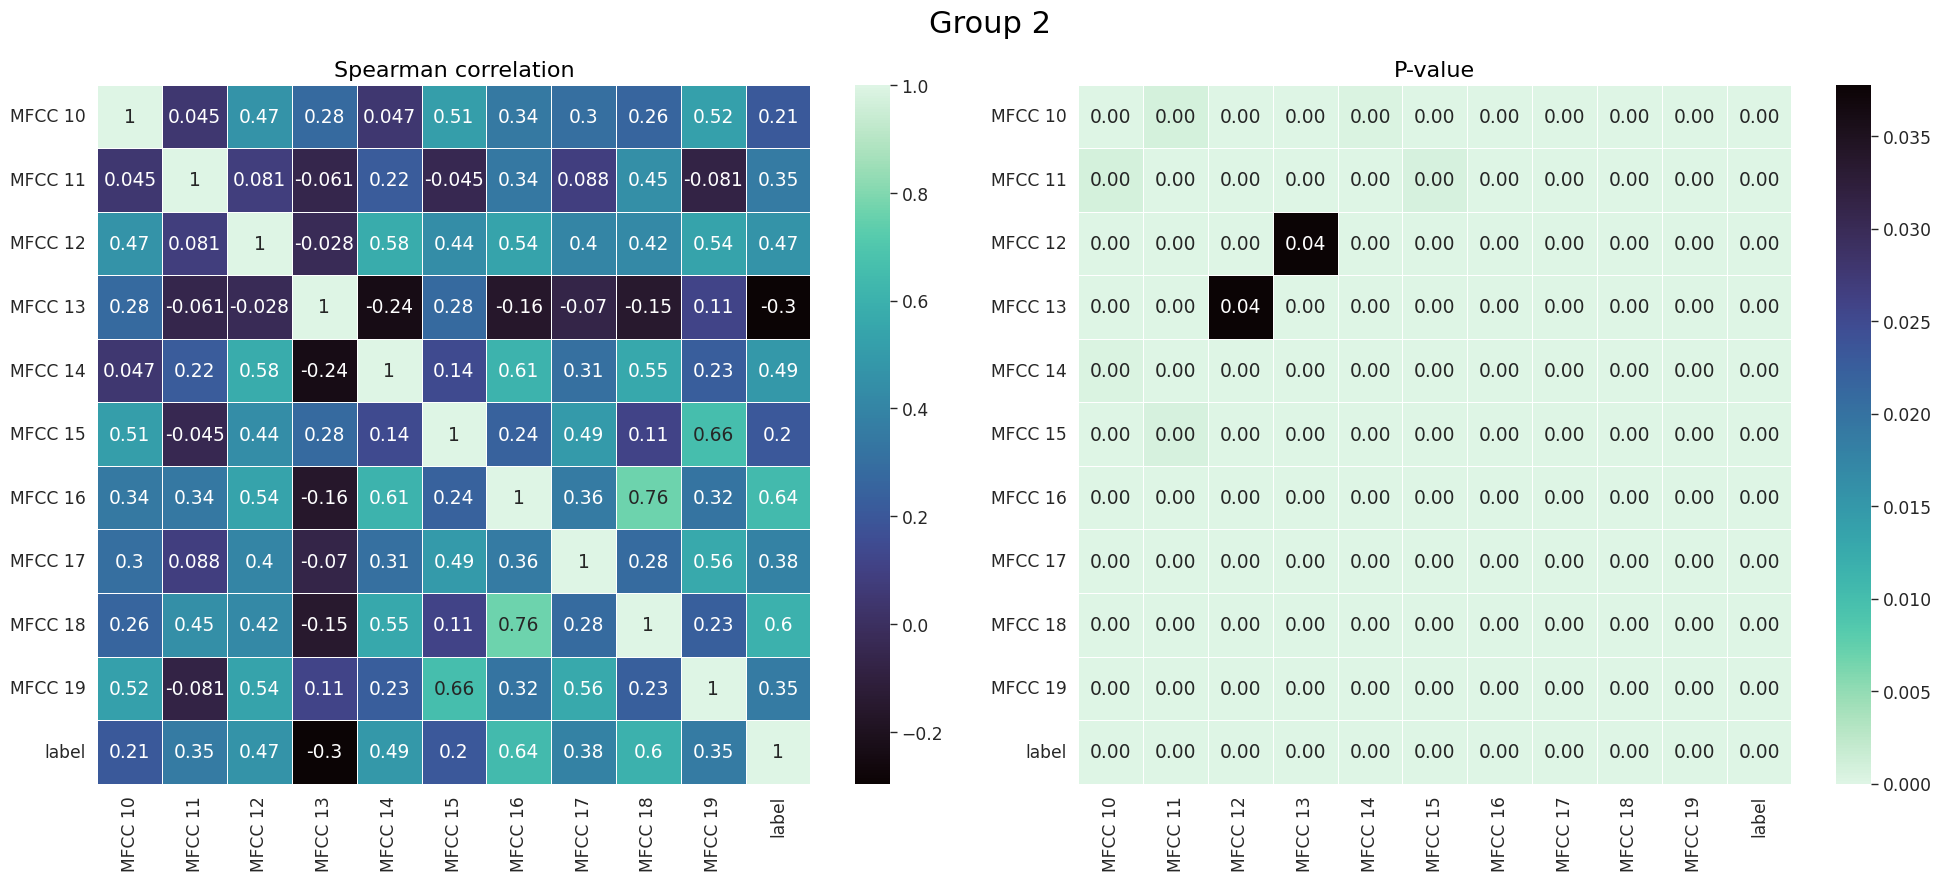

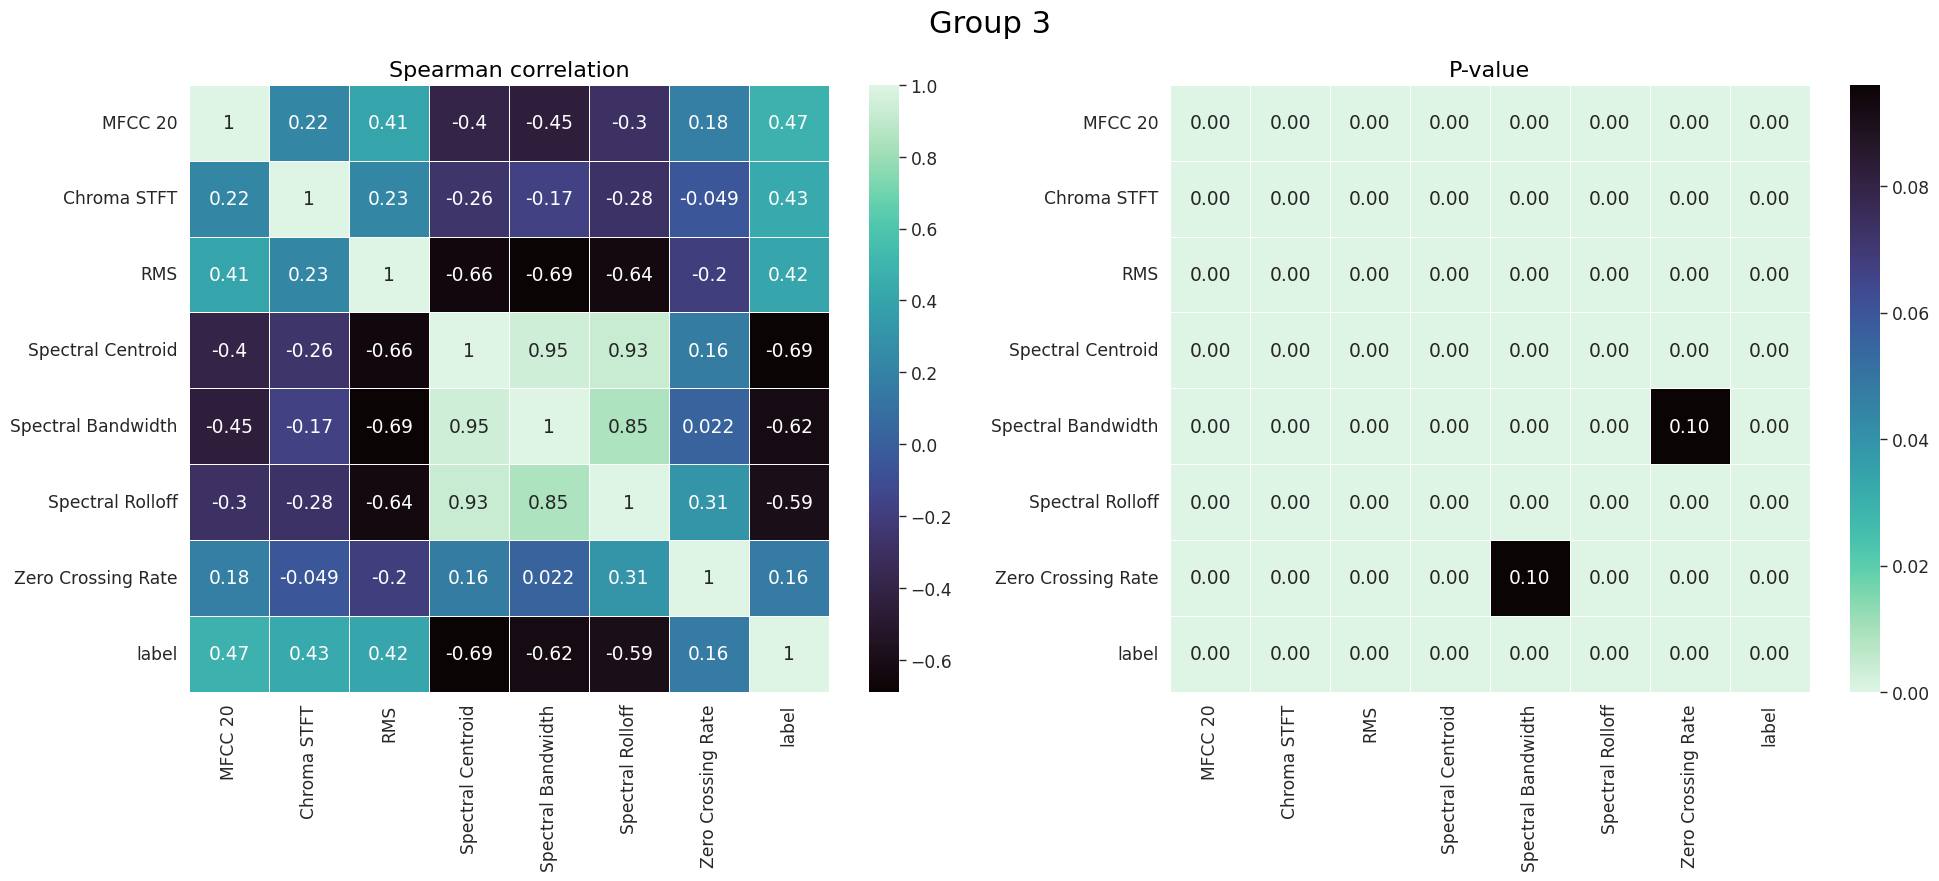

(                     MFCC 20  Chroma STFT       RMS  Spectral Centroid  \
 MFCC 20             1.000000     0.224510  0.405705          -0.404315   
 Chroma STFT         0.224510     1.000000  0.226187          -0.262511   
 RMS                 0.405705     0.226187  1.000000          -0.655318   
 Spectral Centroid  -0.404315    -0.262511 -0.655318           1.000000   
 Spectral Bandwidth -0.451418    -0.173492 -0.689356           0.946135   
 Spectral Rolloff   -0.297204    -0.284101 -0.639870           0.925542   
 Zero Crossing Rate  0.178613    -0.049022 -0.195852           0.163787   
 label               0.473506     0.428864  0.417049          -0.685175   
 
                     Spectral Bandwidth  Spectral Rolloff  Zero Crossing Rate  \
 MFCC 20                      -0.451418         -0.297204            0.178613   
 Chroma STFT                  -0.173492         -0.284101           -0.049022   
 RMS                          -0.689356         -0.639870           -0.195852   

In [26]:
columns1 = data_df.columns[:9]  # This will give you the first 10 columns
columns1 = columns1.tolist()
columns1.extend(data_df.columns[-1:])  # Extend columns1 with the last column
columns2 = data_df.columns[9:19]
columns2 = columns2.tolist()  # Convert to list if it's not already a list
columns2.extend(data_df.columns[-1:])  # Extend columns2 with the last column

columns3 = data_df.columns[19:]


group1 = data_df[columns1]
group2 = data_df[columns2]
group3 = data_df[columns3]

print_correlation(group1, "Group 1")
print_correlation(group2, "Group 2")
print_correlation(group3, "Group 3")

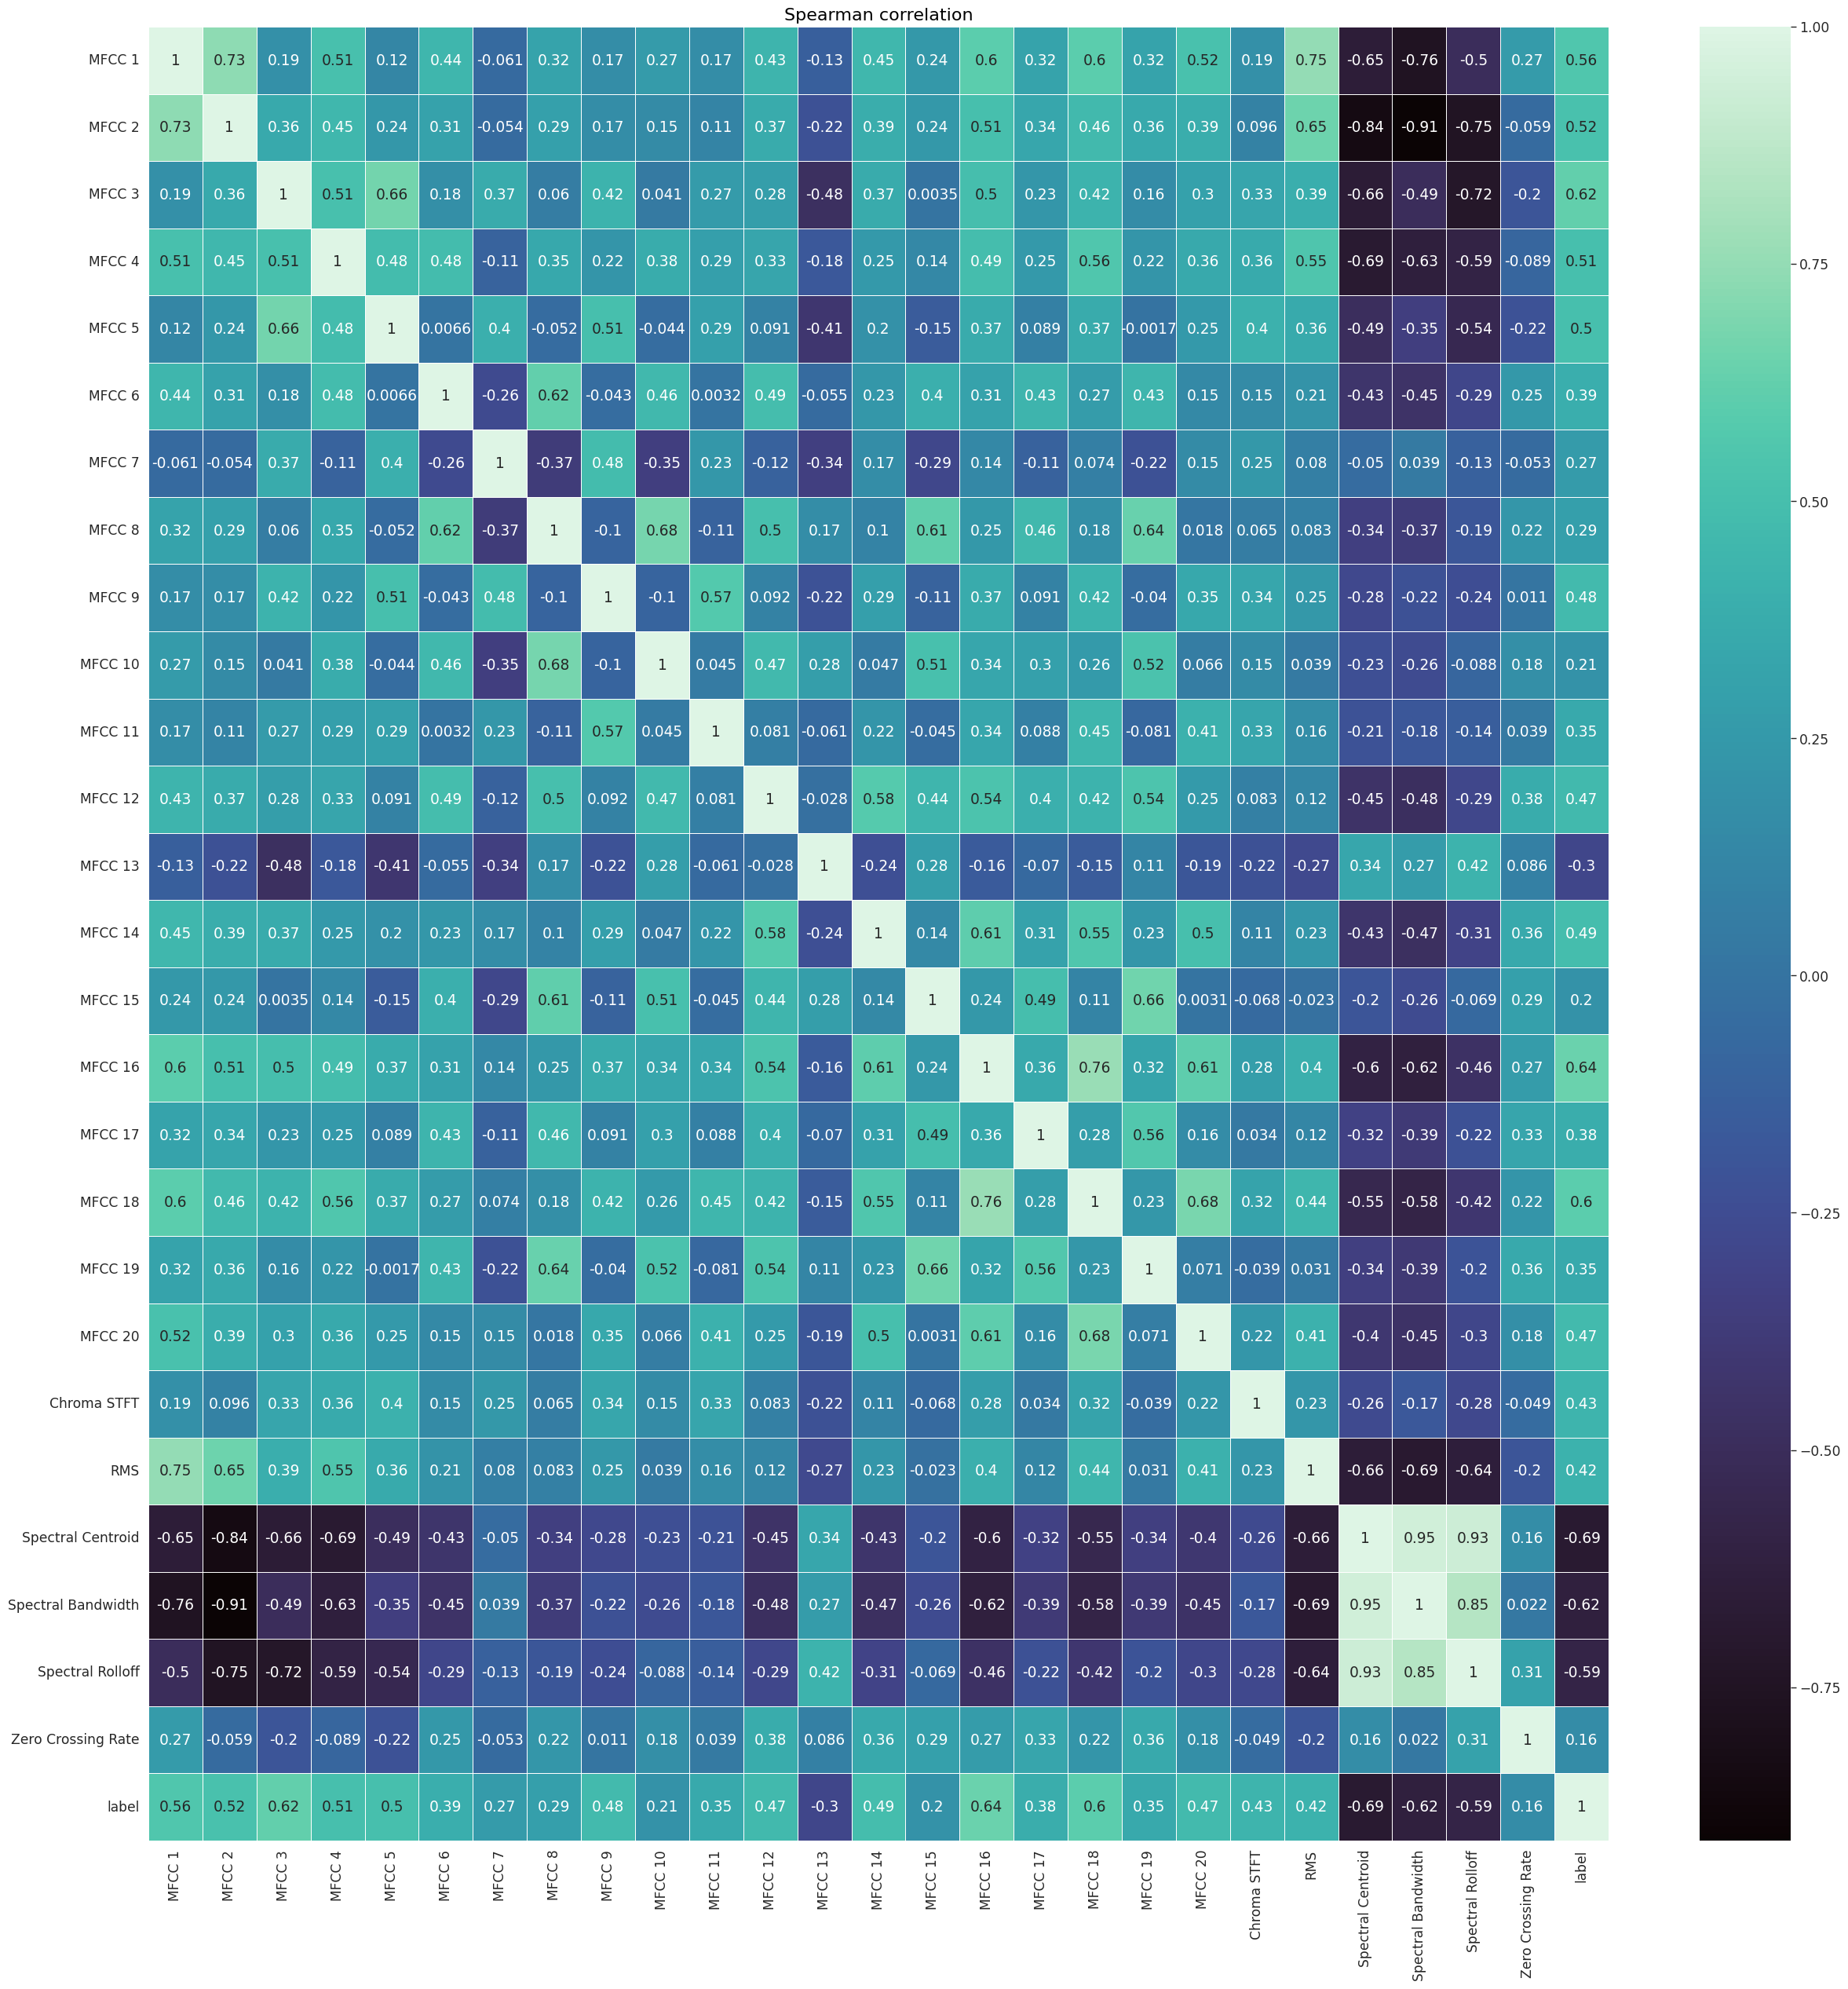

(                      MFCC 1    MFCC 2    MFCC 3    MFCC 4    MFCC 5  \
 MFCC 1              1.000000  0.734677  0.192172  0.513768  0.120386   
 MFCC 2              0.734677  1.000000  0.355573  0.449891  0.236347   
 MFCC 3              0.192172  0.355573  1.000000  0.507880  0.664484   
 MFCC 4              0.513768  0.449891  0.507880  1.000000  0.478358   
 MFCC 5              0.120386  0.236347  0.664484  0.478358  1.000000   
 MFCC 6              0.442693  0.306966  0.181503  0.477472  0.006625   
 MFCC 7             -0.060733 -0.053878  0.369482 -0.105883  0.399299   
 MFCC 8              0.317959  0.294155  0.060441  0.349866 -0.052080   
 MFCC 9              0.168940  0.165275  0.419162  0.219178  0.505118   
 MFCC 10             0.265254  0.151455  0.041290  0.375216 -0.044019   
 MFCC 11             0.170945  0.108474  0.265963  0.289672  0.294113   
 MFCC 12             0.425521  0.366311  0.283036  0.331836  0.090966   
 MFCC 13            -0.127653 -0.224628 -0.476854 -

In [27]:
print_correlation(data_df, "All features",pvalue=False,figuresize=(30,30))

#### 2.3 covariance matrix of the groups

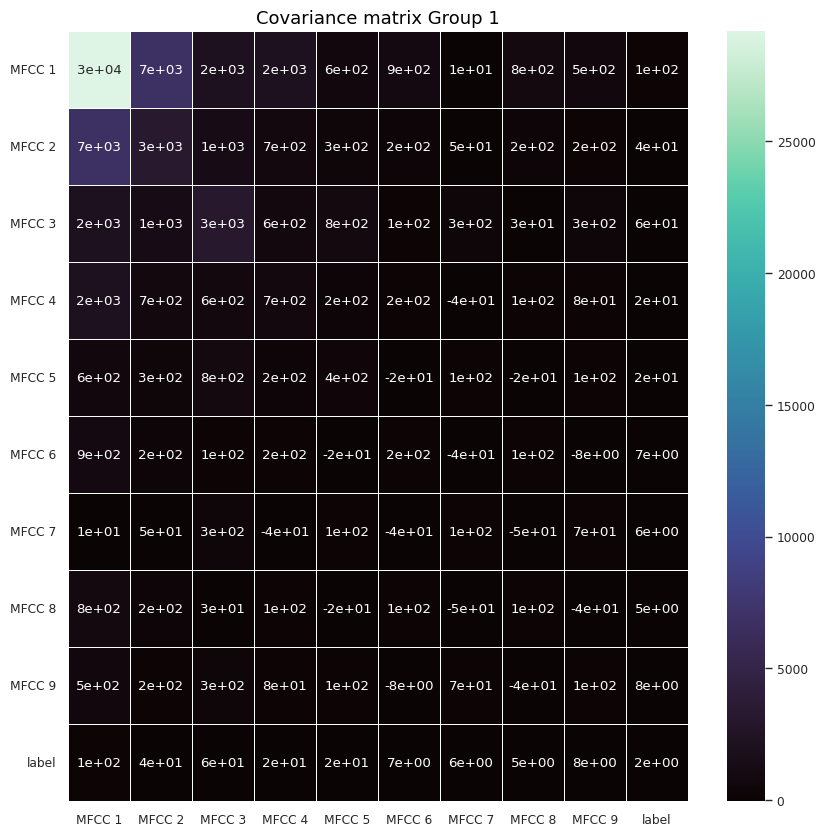

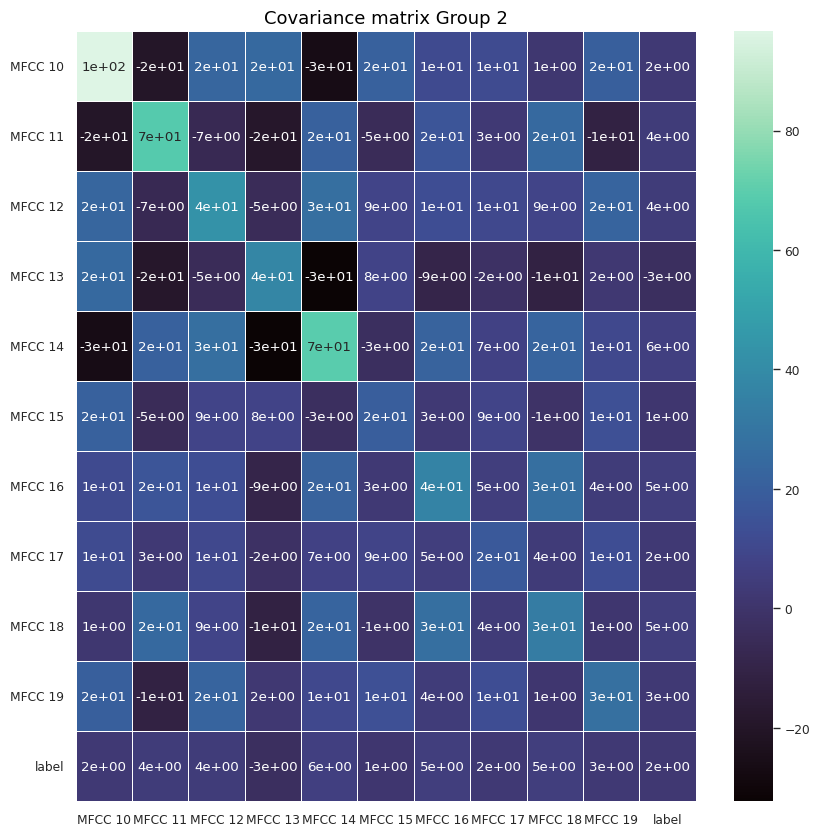

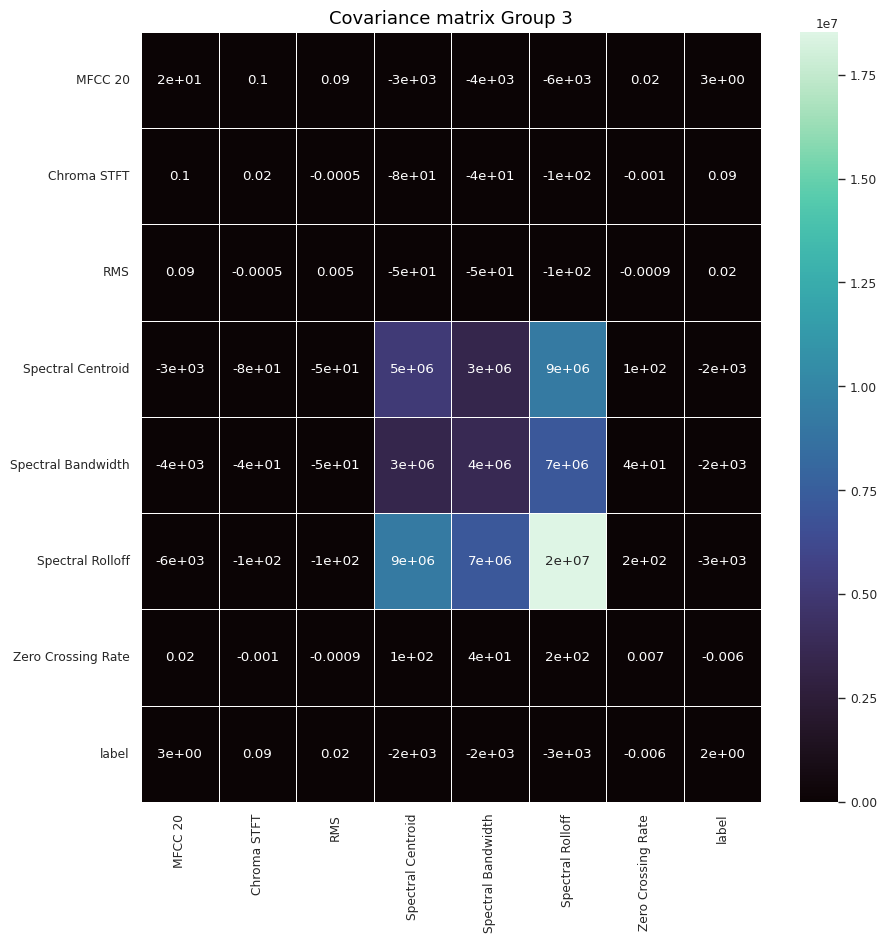

In [28]:
plt.figure(figsize=(10, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(group1.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
plt.yticks(rotation=0)
plt.title("Covariance matrix Group 1", fontsize=13, color="black")
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(group2.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
plt.title("Covariance matrix Group 2", fontsize=13, color="black")
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(group3.cov(), annot=True, cmap="mako", fmt=".1", linewidths=0.5)
plt.title("Covariance matrix Group 3", fontsize=13, color="black")
plt.yticks(rotation=0)
plt.show()

#### 2.4 Feature Selection
1. Remove feature that have a correlation coefficient with the target variable less than 0.3.
2. Remove feature that are highly correlated with other features. 

In [29]:
features_to_drop = correlazione_df[np.abs(correlazione_df["Correlazione"]) <= 0.3].index
print(features_to_drop)
data_df.drop(columns=features_to_drop, inplace=True)

## Remove also 'Spectral Centroid' and 'Spectral Bandwidth' as they are highly correlated with 'Spectral Rolloff' and all the other features

data_df.drop(columns=["Spectral Centroid", "Spectral Bandwidth"], inplace=True)

Index(['MFCC 7', 'MFCC 8', 'MFCC 10', 'MFCC 13', 'MFCC 15',
       'Zero Crossing Rate'],
      dtype='object', name='Feature')


#### 2.5 Outliers Detection

In [30]:
outliers = detect_outliers_iqr(data_df,q1=0.15,q3=0.85)
outliers

MFCC 1      MFCC 2     MFCC 3     MFCC 4     MFCC 5     MFCC 6  \
139   -87.081650   40.001865 -10.279897  -7.915576 -15.834294 -13.083801   
140  -124.589424   77.980995 -16.615011  -7.045231 -14.094812  -1.747072   
750   -31.954195   42.681332 -21.319799  -6.604276 -27.286190 -11.900779   
1146   21.819878   55.924694 -29.800127   9.916588 -10.512742  -8.182891   
1289  -10.260088   48.197262 -20.644075  10.832644 -12.123762  -9.449724   
...          ...         ...        ...        ...        ...        ...   
5605 -367.556213  132.882812  35.352325 -33.967083 -46.651333 -31.383507   
5606 -365.355560  133.270355  34.561108 -34.409801 -46.537895 -30.865614   
5607 -365.443542  133.359497  34.744595 -34.442303 -46.530655 -30.946211   
5608 -365.430847  133.589386  34.496113 -34.910744 -46.531483 -30.873878   
5649 -469.054993   50.531185 -92.321106  -2.230212 -43.581524  -1.818482   

         MFCC 9    MFCC 11    MFCC 12    MFCC 14    MFCC 16    MFCC 17  \
139   13.852941  10.116105 -23.266781  -1.447170   2.997334  10.901670   
140    8.854988   8.515491  -2.928376  -5.467822   3.691870  -2.086142   
750    6.736482  29.477243  30.673729 -19.852928 -13.572035   9.272676   
1146  15.572565  14.317560  -1.429271  -7.764305   1.976781   0.771885   
1289  17.996296  15.230813   7.800886  -9.868225   2.415682   4.239021   
...         ...        ...        ...        ...        ...        ...   
5605 -22.650438 -12.904780  -7.292011   2.759265  -0.396653  -1.293178   
5606 -22.754826 -12.521575  -7.504954   2.433403  -0.055938  -1.709119   
5607 -22.679838 -12.541057  -7.554356   2.396983  -0.083808  -1.689568   
5608 -22.475349 -12.521355  -7.488650   2.541603  -0.169374  -1.804165   
5649 -40.127544 -36.612720  -0.667978 -36.760235 -11.156795 -14.363822   

        MFCC 18   MFCC 19    MFCC 20  Chroma STFT       RMS  Spectral Rolloff  \
139   11.613154 -4.021358  -6.606030     0.241479  0.572086       1049.072266   
140   13.207149  5.673128  -5.128115     0.429759  0.335111        843.750000   
750    9.574444  4.930809   3.026466     0.253951  0.648416        880.126953   
1146  14.318357  3.134422  -3.155195     0.385211  0.574451       1050.781250   
1289   7.224802  9.611977   5.097943     0.289184  0.621783       1030.029297   
...         ...       ...        ...          ...       ...               ...   
5605  -1.775916 -3.656525  -5.075859     0.182305  0.493645        569.268588   
5606  -2.243785 -3.428501  -4.841979     0.176251  0.496415        606.147293   
5607  -2.340287 -3.569465  -4.742530     0.174675  0.497273        546.992861   
5608  -2.577159 -3.840359  -4.599680     0.173721  0.497690        511.846713   
5649  -6.674349  2.033750 -17.092096     0.619386  0.011363       5582.613032   

      label  
139     3.0  
140     3.0  
750     3.0  
1146    3.0  
1289    3.0  
...     ...  
5605    0.0  
5606    0.0  
5607    0.0  
5608    0.0  
5649    0.0  

[186 rows x 19 columns]

In [31]:
new_data_df = data_df.drop(outliers.index, axis=0)
new_data_df.groupby("label")

print("class count before removing outliers")
class_counts = data_df["label"].value_counts()
print(class_counts)

print("class count after removing outliers")
class_counts = new_data_df["label"].value_counts()
print(class_counts)

class count before removing outliers
label
3.0    2161
0.0    2000
2.0    1149
4.0     247
1.0     124
Name: count, dtype: int64
class count after removing outliers
label
3.0    2155
0.0    1837
2.0    1132
4.0     247
1.0     124
Name: count, dtype: int64


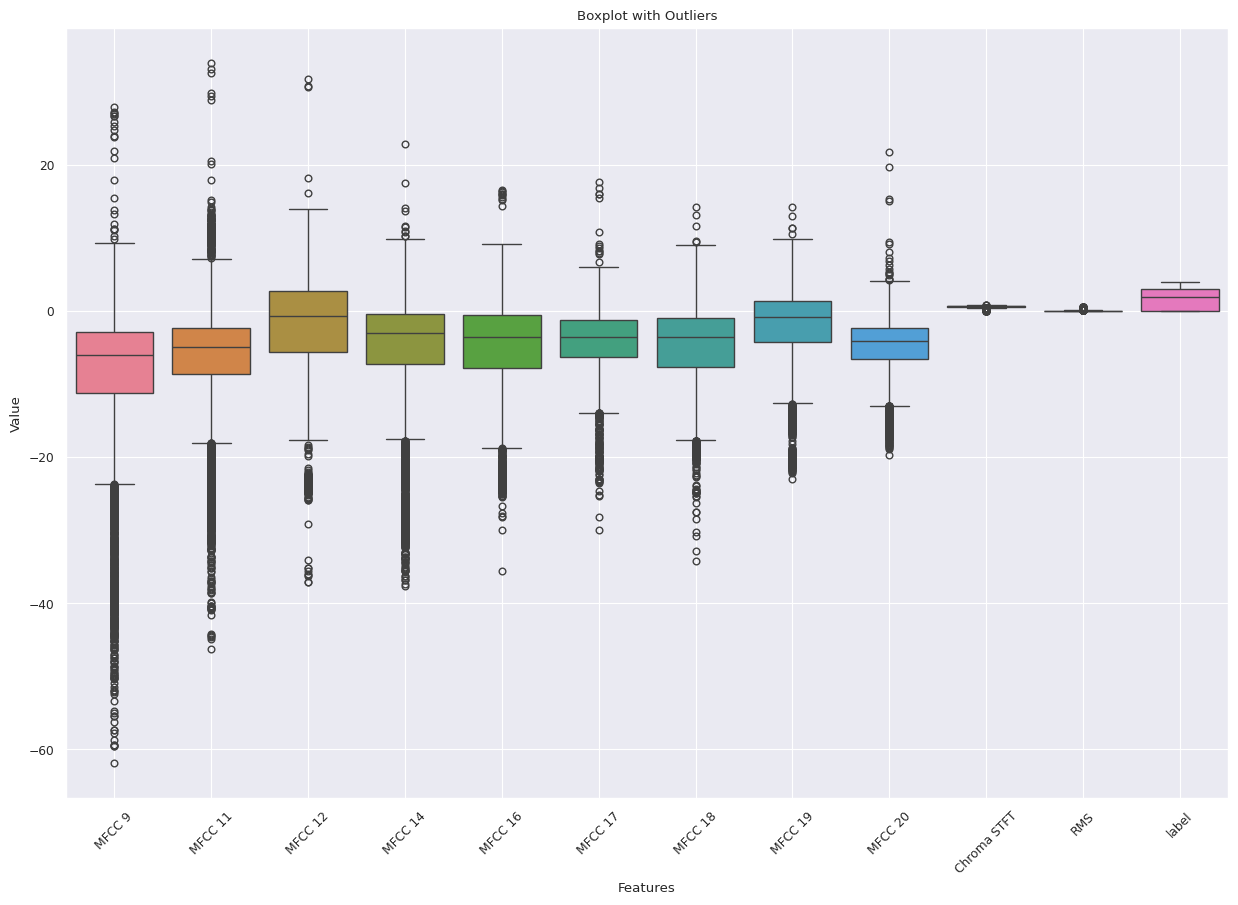

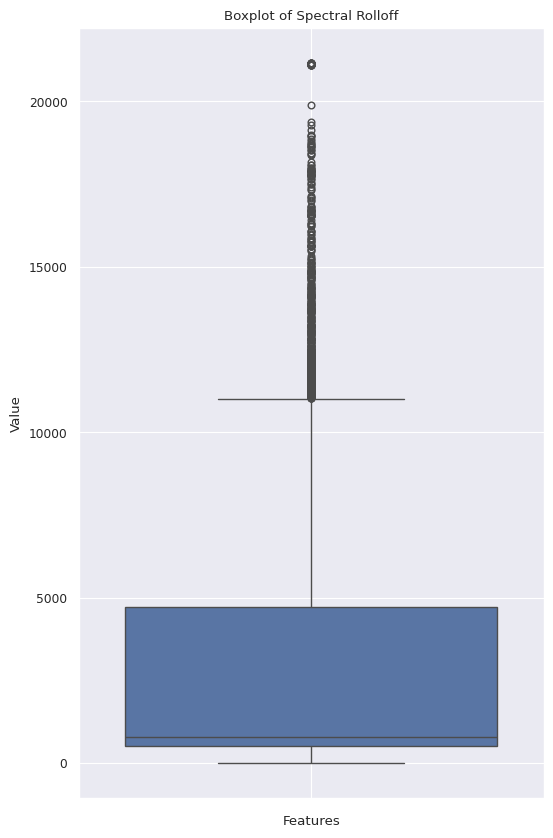

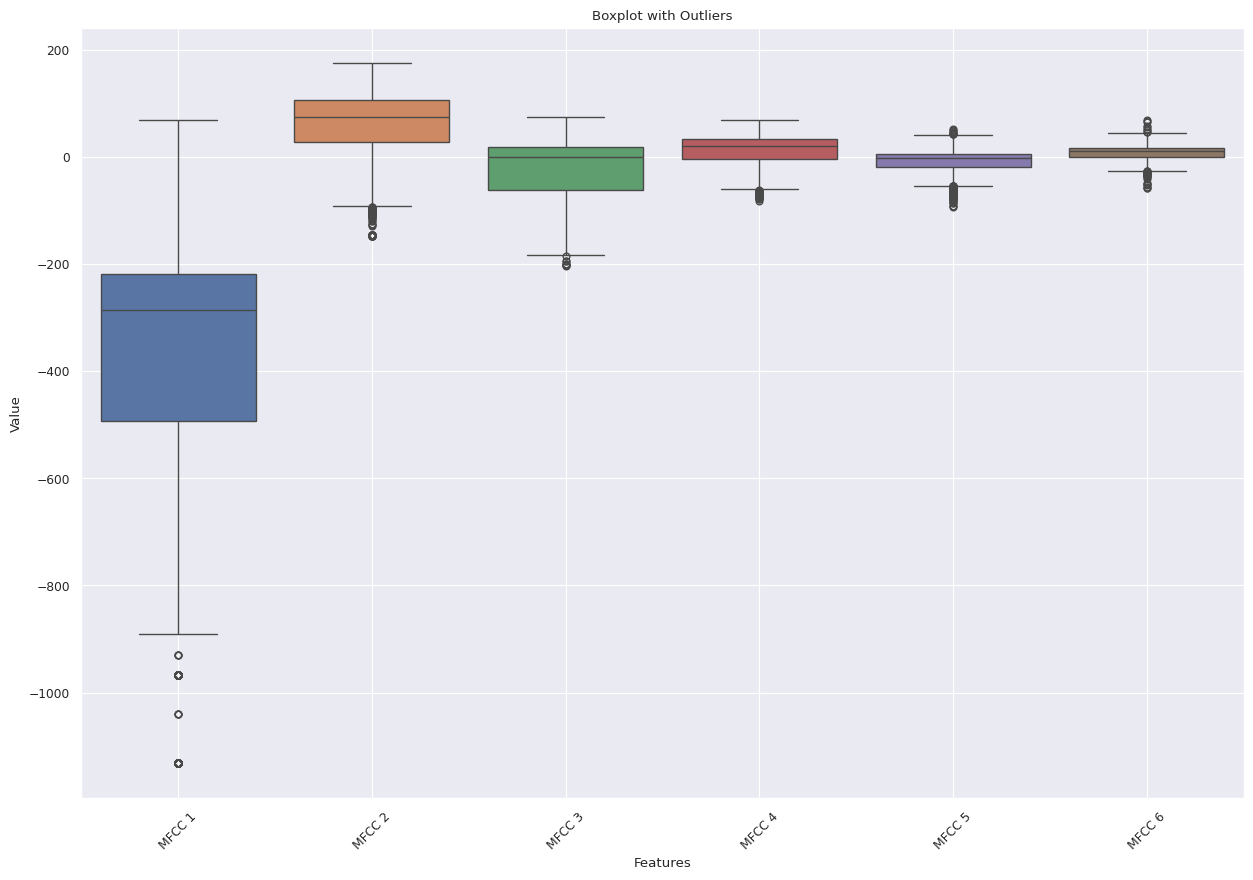

In [32]:
# Create a boxplot with outliers shown
plt.figure(figsize=(15, 10))
sns.boxplot(
    data=data_df.drop(
        columns=[
            "Spectral Rolloff",
            "MFCC 1",
            "MFCC 2",
            "MFCC 3",
            "MFCC 4",
            "MFCC 5",
            "MFCC 1",
            "MFCC 6",],
        inplace=False,
    ),
    showfliers=True,
)
plt.title("Boxplot with Outliers")
plt.xlabel("Features")
plt.ylabel("Value")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

# Create a boxplot with outliers shown
plt.figure(figsize=(6, 10))
sns.boxplot(data=data_df["Spectral Rolloff"], showfliers=True, )
plt.title("Boxplot of Spectral Rolloff")
plt.xlabel("Features")
plt.ylabel("Value")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

# Create a boxplot with outliers shown
plt.figure(figsize=(15, 10))
sns.boxplot(
    data=data_df[
        [
            "MFCC 1",
            "MFCC 2",
            "MFCC 3",
            "MFCC 4",
            "MFCC 5",
            "MFCC 1",
            "MFCC 6",
        ]
    ],
    showfliers=True,
)
plt.title("Boxplot with Outliers")
plt.xlabel("Features")
plt.ylabel("Value")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [33]:
# columns1 = new_data_df.columns[:6]  # This will give you the first 10 columns
# columns1 = columns1.tolist()
# columns1.extend(new_data_df.columns[-1:])  # Extend columns1 with the last column
# columns2 = new_data_df.columns[6:12]
# columns2 = columns2.tolist()  # Convert to list if it's not already a list
# columns2.extend(new_data_df.columns[-1:])  # Extend columns2 with the last column

# columns3 = data_df.columns[12:]


# group1 = data_df[columns1]
# group2 = data_df[columns2]
# group3 = data_df[columns3]

# g = sns.PairGrid(group1, hue="label", palette="viridis")
# g.map_upper(sns.scatterplot)
# g.map_lower(
#     sns.kdeplot,
#     fill=True,
# )
# g.map_diag(sns.kdeplot, fill=True)
# g.add_legend(title="Label")
# plt.show()

# g = sns.PairGrid(group2, hue="label", palette="viridis")
# g.map_upper(sns.scatterplot)
# g.map_lower(
#     sns.kdeplot,
#     fill=True,
# )
# g.map_diag(sns.kdeplot, fill=True)
# g.add_legend(title="Label")
# plt.show()

# g = sns.PairGrid(group3, hue="label", palette="viridis")
# g.map_upper(sns.scatterplot)
# g.map_lower(
#     sns.kdeplot,
#     fill=True,
# )
# g.map_diag(sns.kdeplot, fill=True)
# g.add_legend(title="Label")
# plt.show()

### 4. Try PCA to reduce the dimensionality of the data

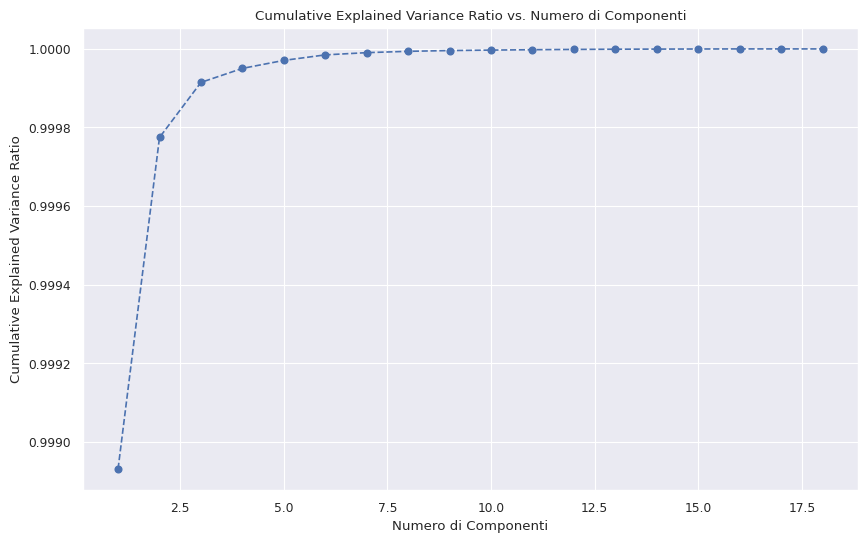

In [34]:
X = new_data_df.drop(columns=["label"]).values
# Inizializza PCA
pca = PCA()

# Adatta PCA ai dati
pca.fit(X)

# Calcola il rapporto di varianza spiegata cumulativa attraverso i componenti
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot del rapporto di varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.xlabel("Numero di Componenti")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio vs. Numero di Componenti")
plt.grid(True)
plt.show()

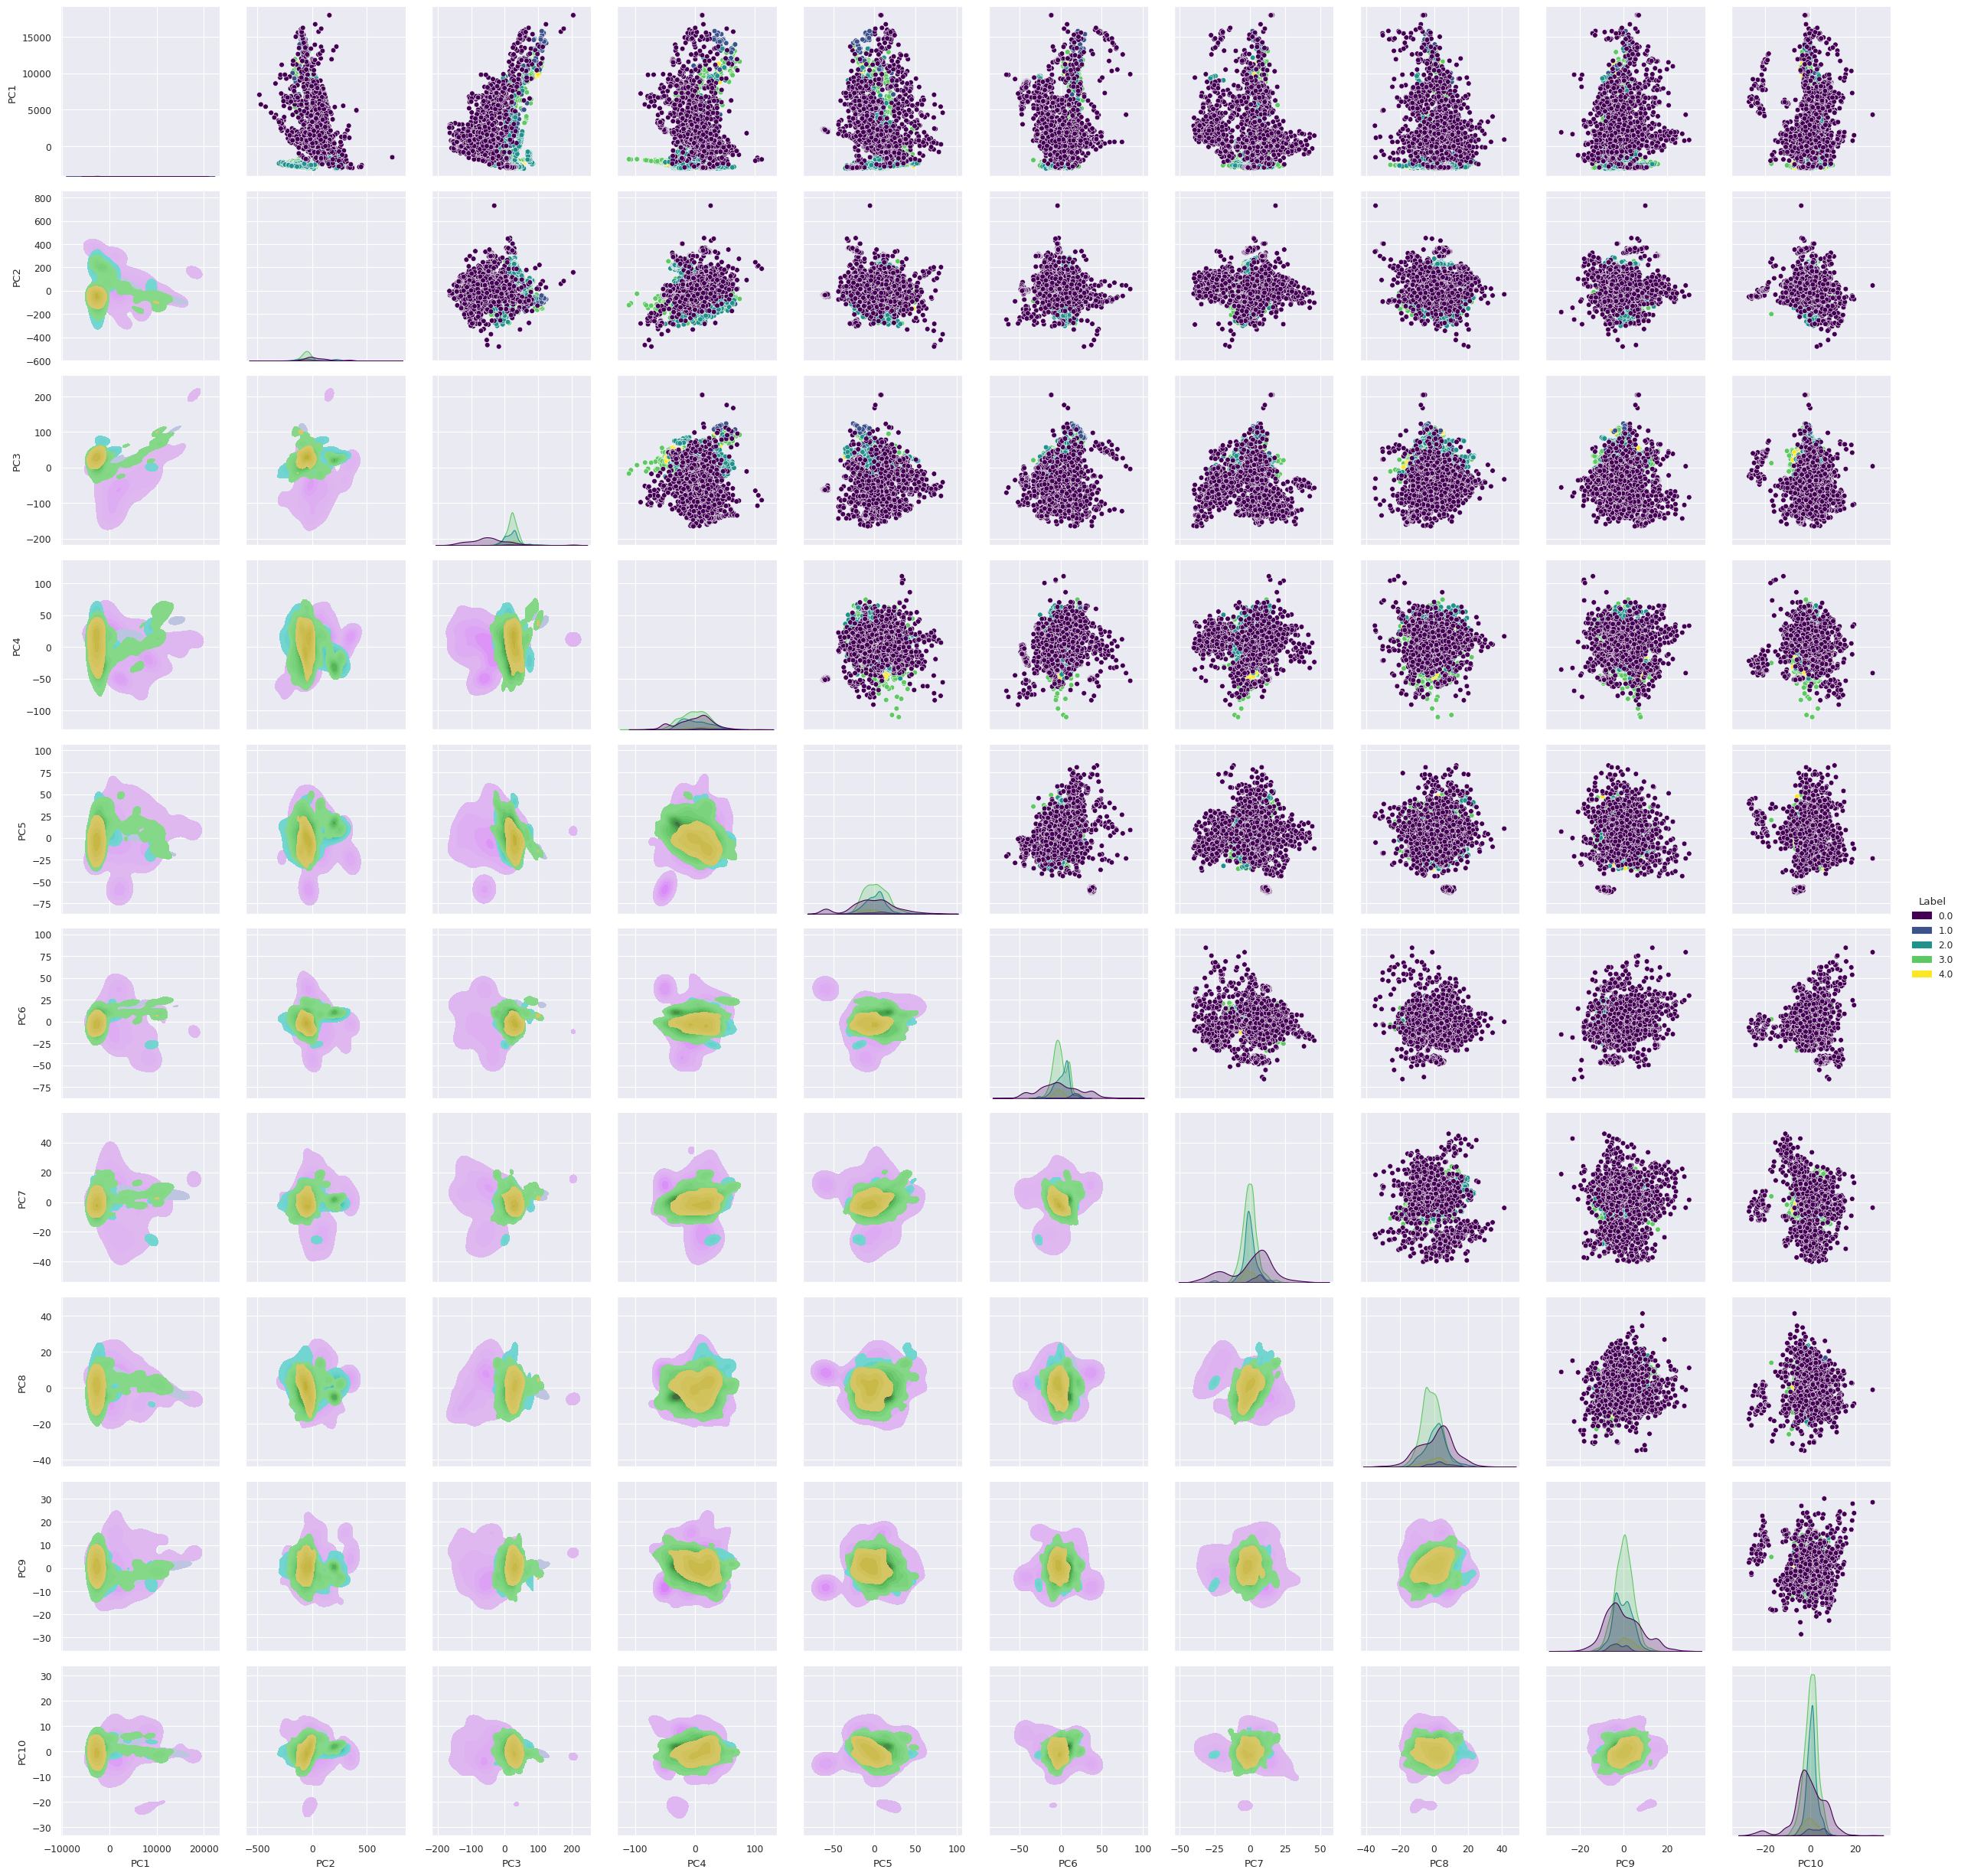

In [39]:
pc = PCA(n_components=10)
X= new_data_df.drop(columns=["label"]).values
pc_df = pd.DataFrame(pc.fit_transform(X), columns=[f"PC{i}" for i in range(1, 11)])
pc_df["label"] = new_data_df["label"]
g = sns.PairGrid(pc_df, hue="label", palette="viridis")
g.map_upper(sns.scatterplot)
g.map_lower(
    sns.kdeplot,
    fill=True,
)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend(title="Label")
plt.show()

### 4. Feature Normalization
